In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


In [2]:
df_all = pd.DataFrame()

In [3]:
# 08092024: synthetic data v3 
# 08052024: synthetic data v1 
# 08022024: baselines skillit
# perp_folders = ["../output/08092024/", "../output/08052024/", "../output/08032024/"]
# perp_folders = ["../output/synthetic_fractions_copy/"]
# perp_folders = ["../output/untrained_synthetic_fractions/"]
perp_folders = ["../output/synthetic_fractions2/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    # print(files)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file:
            continue 

        # if "english" not in file:
        #     continue 
                
        if ".log" in file:
            continue
        print(file)
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "proportions" in run:
                continue 
        
            if "seed" not in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        
        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])
    


../output/synthetic_fractions2/synthetic_10_split
../output/synthetic_fractions2/synthetic_10_split/seed_3_checkpoint-0.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_1_checkpoint-0.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_2_checkpoint-100.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_0_checkpoint-500.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_3_checkpoint-600.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_0_checkpoint-0.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_4_checkpoint-400.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_3_checkpoint-400.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_1_checkpoint-200.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_0_checkpoint-600.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_1_checkpoint-400.pkl
../output/synthetic_fractions2/synthetic_10_split/seed_0_checkpoint-100.pkl
../output/synthetic_fractions2/synthetic_10_

In [5]:
def aggregate_skill(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "skill_perplexity"
        metric = total_ppl/count_ppl
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "skill_loss"
        metric = total_loss/count_loss

    names = {metric_name: metric}
    
    return pd.Series(names, index=[metric_name])



In [6]:
sorted(df_all.method.unique())

# dfl_complete = df_all.copy()

['real_00_split',
 'real_01_split',
 'real_02_split',
 'real_04_split',
 'real_05_split',
 'real_095_split',
 'real_09_split',
 'real_10_split',
 'synthetic_00_split',
 'synthetic_01_split',
 'synthetic_02_split',
 'synthetic_04_split',
 'synthetic_05_split',
 'synthetic_095_split',
 'synthetic_09_split',
 'synthetic_10_split',
 'target_only']

In [18]:

methods = [] 
proportions = []
for method in sorted(df_all.method.unique()):
    # print(method)
    if "synthetic" in method and "split" in method and "v4" not in method: 
        methods.append(method) 
        split_str = method.split("_")[-2] 
        # split_str should be of the format 0d+, convert to 0.d+
        split_str = split_str[0] + "." + split_str[1:]
        proportions.append(float(split_str))

methods, proportions

# sort methods and proportions according to proportions
methods = [x for _, x in sorted(zip(proportions, methods))]
proportions = sorted(proportions)

In [19]:
methods, proportions

(['synthetic_00_split',
  'synthetic_01_split',
  'synthetic_02_split',
  'synthetic_04_split',
  'synthetic_05_split',
  'synthetic_09_split',
  'synthetic_095_split',
  'synthetic_10_split'],
 [0.0, 0.1, 0.2, 0.4, 0.5, 0.9, 0.95, 1.0])

/tmp/ipykernel_1909255/2109095600.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
/tmp/ipykernel_1909255/2109095600.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).

Text(0.5, 1.0, 'Targeted learning of Spanish question generation - synthetic Spanish QA')

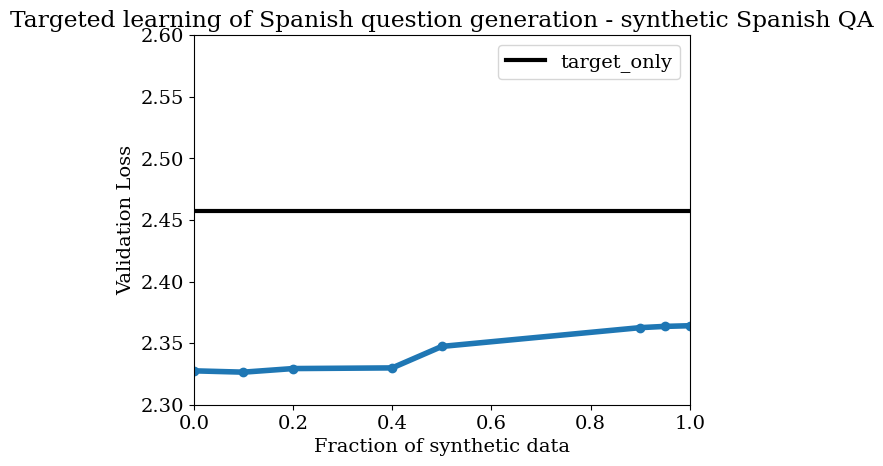

In [20]:
plt.figure()
seeds = [0, 1, 2, 3, 4]
losses = [] 

for i, method in enumerate(methods):
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    # print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_overall.set_index("checkpoint", inplace=True)
    df_overall.drop([0], inplace=True)

    # find the maximum checkpoint 
    max_checkpoint = df_shuffled.index.max()
    assert max_checkpoint == 600
    df_shuffled.loc[df_shuffled.index == max_checkpoint].skill_loss
    # df_shuffled.loc[df_shuffled.skill == "question_generation_spanish_spanish"].skill_loss.plot(marker="o" lw=3)
    losses.append(df_shuffled.loc[(df_shuffled.index == max_checkpoint) & (df_shuffled.skill == "question_generation_spanish_spanish")].skill_loss.values[0])
    # print(df_shuffled.loc[df_shuffled.index == df_shuffled.index.max()].skill_loss)

target_only_method = 'target_only'
df_shuffled = df_all.loc[df_all.method == target_only_method].sort_index()
df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
df_shuffled.set_index("checkpoint", inplace=True)
df_overall.set_index("checkpoint", inplace=True)
df_overall.drop([0], inplace=True)

# find the maximum checkpoint
max_checkpoint = df_shuffled.index.max()
target_loss = df_shuffled.loc[(df_shuffled.index == max_checkpoint) & (df_shuffled.skill == "question_generation_spanish_spanish")].skill_loss.values[0]

plt.xlim(0, 1)
plt.ylim(2.3, 2.6)
plt.plot(proportions, losses, marker="o", lw=4)
plt.axhline(target_loss, label="target_only", color="black", lw=3)
plt.xlabel("Fraction of synthetic data")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
# plt.grid()
plt.title("Targeted learning of Spanish question generation - synthetic Spanish QA")

In [21]:
synthetic_proportions = list(proportions)
synthetic_losses = list(losses)

In [34]:
methods = [] 
proportions = []
for method in sorted(df_all.method.unique()):
    # print(method)
    if "real" in method and "split" in method: 
        methods.append(method) 
        split_str = method.split("_")[-2] 
        # split_str should be of the format 0d+, convert to 0.d+
        split_str = split_str[0] + "." + split_str[1:]
        proportions.append(float(split_str))

# proportions = [1 - p for p in proportions]


# sort methods and proportions according to proportions
methods = [x for _, x in sorted(zip(proportions, methods))]
proportions = sorted(proportions)

methods, proportions

(['real_00_split',
  'real_01_split',
  'real_02_split',
  'real_04_split',
  'real_05_split',
  'real_09_split',
  'real_095_split',
  'real_10_split'],
 [0.0, 0.1, 0.2, 0.4, 0.5, 0.9, 0.95, 1.0])

In [35]:
reverse_proportions = [1 - p for p in proportions]

real_00_split
real_01_split


/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).

real_02_split
real_04_split


/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()


real_05_split
real_09_split


/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).

real_095_split
real_10_split


/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
/tmp/ipykernel_1909255/3302093628.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).

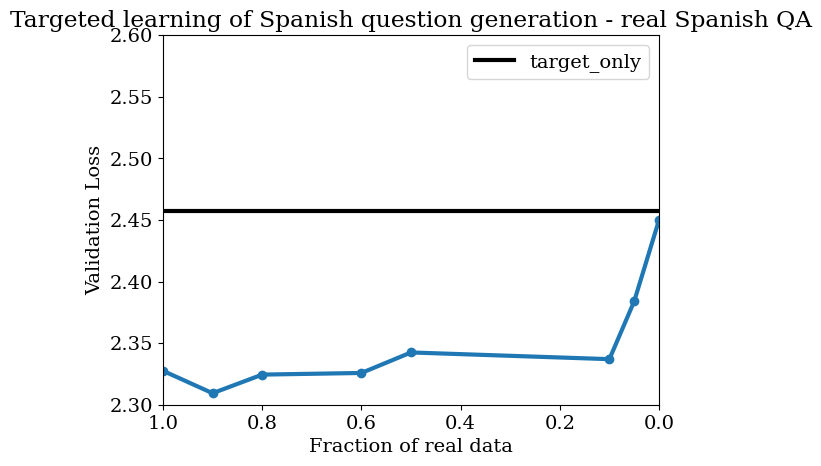

In [36]:
plt.figure()
seeds = [0, 1, 2, 3, 4]
losses = [] 

for i, method in enumerate(methods):
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    # print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    print(method)
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_overall.set_index("checkpoint", inplace=True)
    df_overall.drop([0], inplace=True)

    # find the maximum checkpoint 
    max_checkpoint = df_shuffled.index.max()
    df_shuffled.loc[df_shuffled.index == max_checkpoint].skill_loss
    # df_shuffled.loc[df_shuffled.skill == "question_generation_spanish_spanish"].skill_loss.plot(marker="o" lw=3)
    losses.append(df_shuffled.loc[(df_shuffled.index == max_checkpoint) & (df_shuffled.skill == "question_generation_spanish_spanish")].skill_loss.values[0])
    # print(df_shuffled.loc[df_shuffled.index == df_shuffled.index.max()].skill_loss)

target_only_method = 'target_only'
df_shuffled = df_all.loc[df_all.method == target_only_method].sort_index()
df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
df_shuffled.set_index("checkpoint", inplace=True)
df_overall.set_index("checkpoint", inplace=True)
df_overall.drop([0], inplace=True)

# find the maximum checkpoint
max_checkpoint = df_shuffled.index.max()
target_loss = df_shuffled.loc[(df_shuffled.index == max_checkpoint) & (df_shuffled.skill == "question_generation_spanish_spanish")].skill_loss.values[0]

plt.xlim(0, 1)
plt.ylim(2.3, 2.6)
plt.plot(reverse_proportions, losses, marker="o", lw=3)
plt.axhline(target_loss, label="target_only", color="black", lw=3)
plt.xlabel("Fraction of real data")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
# plt.grid()
plt.title("Targeted learning of Spanish question generation - real Spanish QA")
plt.gca().invert_xaxis()


In [46]:
real_proportions = [1 - p for p in reverse_proportions]
real_losses = list(losses)

In [48]:
real_proportions

[0.0, 0.09999999999999998, 0.19999999999999996, 0.4, 0.5, 0.9, 0.95, 1.0]

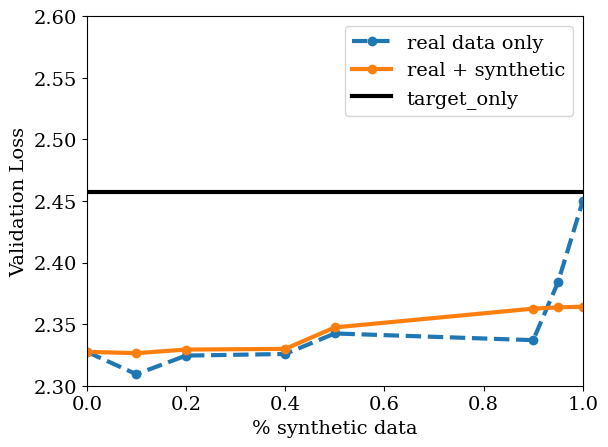

In [49]:
plt.xlim(0, 1)
plt.ylim(2.3, 2.6)
plt.plot(real_proportions, real_losses, marker='o', linestyle='dashed', lw=3, label="real data only")
plt.plot(synthetic_proportions, synthetic_losses, marker="o", lw=3, label="real + synthetic")
plt.axhline(target_loss, label="target_only", color="black", lw=3)
plt.xlabel("% synthetic data")
plt.ylabel("Validation Loss")

plt.legend()

In [15]:
df_all[(df_all.skill == 'question_generation_spanish_spanish') & (df_all.method == 'real_01_split') & (df_all.index == 600)]

,skill,loss,perplexity,average_loss,average_perplexity,method,seed
checkpoint,,,,,,,
600,question_generation_spanish_spanish,"[2.0218475, 2.0927482, 1.8907377, 2.1185877, 2...","[7.5522647, 8.107164, 6.6242533, 8.31938, 10.6...",2.295997,10.404071,real_01_split,3
600,question_generation_spanish_spanish,"[2.4086072, 2.2713459, 1.9501733, 2.1444542, 1...","[11.118465, 9.692436, 7.029905, 8.537381, 5.56...",2.319440,10.776889,real_01_split,0
600,question_generation_spanish_spanish,"[2.2176049, 2.5274093, 1.9652286, 2.2189388, 2...","[9.185305, 12.521026, 7.1365433, 9.197565, 12....",2.325395,10.776578,real_01_split,1
600,question_generation_spanish_spanish,"[2.1315053, 1.484292, 2.1693022, 2.243529, 2.0...","[8.427543, 4.411841, 8.752175, 9.426539, 7.994...",2.303793,10.652494,real_01_split,2
600,question_generation_spanish_spanish,"[1.8304633, 2.2301936, 2.737932, 2.1515741, 1....","[6.236775, 9.301667, 15.454991, 8.598383, 5.89...",2.302265,10.521739,real_01_split,4


In [16]:
max_checkpoint = df_shuffled.index.max()
df_shuffled.loc[(df_shuffled.index == max_checkpoint) & (df_shuffled.skill == "question_generation_spanish_spanish")].skill_loss.values

array([2.45709343])

In [17]:
target_loss.skill_loss.values

AttributeError: 'numpy.float64' object has no attribute 'skill_loss'

In [ ]:
losses

[                                          skill  skill_loss
 checkpoint                                                 
 600         question_generation_spanish_spanish    2.357853,
                                           skill  skill_loss
 checkpoint                                                 
 600         question_generation_spanish_spanish    2.365118,
                                           skill  skill_loss
 checkpoint                                                 
 600         question_generation_spanish_spanish    2.415247]